# Data Science Project: Predicting Usage of a Video Game Research Server

# Introduction

### Background

This project investigated whether a Minecraft player's experience level can be predicted by their age and the number of hours they have played. A Minecraft server was set up by a research group in the Department of Computer Science at UBC, led by Frank Wood. Their objective was to record how players navigate the world. However, running this kind of research requires a lot of resources such as software licenses and server hardware. To use these resources efficiently, they must target players that are most likely to contribute a large amount of data, in terms of played hours. 

Therefore, this project aims to discover the relationship between player characteristics and experience level using the K-nearest neighbour algorithm and to evaluate the effectiveness of KNN in this context . to determine whether predictive modelling can be useful in their recruiting efforts and maximize data collection.

### Question

Can we predict a Minecraft player's experience level based on their age and the number of hours they have played?

### Data Description

In order to investigate the question, the players.csv data set will be used. This file includes information of the unique players and data about each player. This data set has 7 variables and 196 observation. Each observation represents a player and some of their characteristics. The variables include:

- experience: the player's experience level; Beginner, Amateur, Regular, Pro, and Veteran.
- subscribe: whether or not the player would be interested in subscribing to a game-related newsletter
- hashedEmail: the player's email that has been processed to encrypt it
- played_hours: the amount of hours the player played on the server
- name: the name of the player
- gender: the gender of the player
- Age: the age of the player

#### Issues with the data
1. Amongst the variables, there are 3 variables that are important to our data analysis: experience, played_hours, and Age. So, in the data cleaning/wrangling step, we will create a subset of the columns specified.

2. We noticed that the experience variable, our response variable, is stored as a character type. To make it suitable for our algorithm, we will change the experience variable into a categorical variable using as_factor(). 

3. Using the group_by() and summarise() functions to see how many players of each experience level there are, there seems to be class imbalance amongst the levels. There are far fewer observations of the "Pro" experience level than "Amateur". To address this issue, an oversampling step will be added to the recipe using the step_upsample() function from the themis R package.

After loading the necessary packages and data, we will begin the analysis by addressing the issues above in order to make our data suitable for the analysis.

# Methods and Results
This section of the report will be the codes that make up the analysis. There are notes in each cell, or above, that will narrate the analysis.

### Additional information
We decided that KNN classification was the appropriate method to use for this analysis because it is a very intuitive algorithm and our target variable (experience level) is categorical. The KNN model assumes that similar observations are near each other, therefore target variable of a new observation can be predicted based on the nearby points. Since KNN relies on Euclidian distance to determine which points are closest, we need to scale and center the predictor variables. 
  
  
- What are the potential limitations or weaknesses of the method selected?

KNN classification can struggle with missing data and class imbalance, which will be explored. 
  
- How did you compare and select the model?
Note: you should also think about the following:

- How are you going to process the data to apply the model? For example: Are you splitting the data? How? How many splits?
- What proportions will you use for the splits? At what stage will you split? Will there be a validation set? Will you use cross validation?
- creates a visualization of the analysis

note: all figures should have a figure number and a legend

In [12]:
# Run this cell before continuing
library(tidyverse)
library(tidymodels)
library(themis)

In [13]:
# Loading the player data set
player_data <- read_csv("data/players.csv")

head(player_data) # to view the first few rows

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


experience,subscribe,hashedEmail,played_hours,name,gender,Age
<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<dbl>
Pro,TRUE,f6daba428a5e19a3d47574858c13550499be23603422e6a0ee9728f8b53e192d,30.3,Morgan,Male,9
Veteran,TRUE,f3c813577c458ba0dfef80996f8f32c93b6e8af1fa939732842f2312358a88e9,3.8,Christian,Male,17
Veteran,FALSE,b674dd7ee0d24096d1c019615ce4d12b20fcbff12d79d3c5a9d2118eb7ccbb28,0.0,Blake,Male,17
Amateur,TRUE,23fe711e0e3b77f1da7aa221ab1192afe21648d47d2b4fa7a5a659ff443a0eb5,0.7,Flora,Female,21
Regular,TRUE,7dc01f10bf20671ecfccdac23812b1b415acd42c2147cb0af4d48fcce2420f3e,0.1,Kylie,Male,21
Amateur,TRUE,f58aad5996a435f16b0284a3b267f973f9af99e7a89bee0430055a44fa92f977,0.0,Adrian,Female,17


### Exploring the data set

Looking at the players data set, we see that there are more variables than needed for the analysis. To answer our question, we are interested in the experience and Age columns. Additionally, KNN classification (the algorithm used for this analysis) requires for the response variable to be a factor/categorical variable. 

To prepare the data and make it suitable for KNN classification, we will be performing the following tasks:

- select() to create a subset with only the columns needed (experience and Age)
- mutate() to change the experience variable into a categorical variable,
- mutate() + if_else() + na.rm = TRUE, to impute any missing data using the mean of the available data

The results are assigned to an object called player_wrangle

In [14]:
player_wrangle <- player_data |>
  select(experience, played_hours, Age) |>
  mutate(
    experience = as_factor(experience),
    played_hours = if_else(is.na(played_hours), mean(played_hours, na.rm = TRUE), played_hours),
    Age = if_else(is.na(Age), mean(Age, na.rm = TRUE), Age))

head(player_wrangle) # to view the first few rows

experience,played_hours,Age
<fct>,<dbl>,<dbl>
Pro,30.3,9
Veteran,3.8,17
Veteran,0.0,17
Amateur,0.7,21
Regular,0.1,21
Amateur,0.0,17


In [15]:
# Seeing how many of each experience level there is
exp_count <- player_wrangle |>
                group_by(experience) |>
                summarise(count = n())
exp_count

experience,count
<fct>,<int>
Pro,14
Veteran,48
Amateur,63
Regular,36
Beginner,35


From this summary, we can see that there is class imbalance, the Amateur level is much more common than Pro!

### Preprocessing the data

Before balancing the classes, we will split the data set into training and testing, and only balance the training set. This prevents any information from the testing set leaking into the model during training.

We will split the data so that 70% of the original data set goes into the training set and 30% into the testing set. Additionally, we will stratify by the experience variable so that roughly an equal proportion of each class will end up in both of the subsets.

Later in the analysis, we will be performing a k-fold cross validation to evaluate the performance of our classifier and choose the number of neighbours to use.  

In [16]:
# run this cell to split the data
set.seed(1234)
player_split <- initial_split(player_wrangle, prop = 0.70, strata = experience)
player_training <- training(player_split)
player_testing <- testing(player_split)

To address the class imbalance in the training set, we will use the step_upsample() in our recipe to oversample the rare class and give them more voting power.

In [17]:
# Run this cell to balance the classes
player_recipe <- recipe(experience ~ played_hours + Age, data = player_training) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    step_upsample(experience, over_ratio = 1, skip = TRUE)

# Let's see if it worked
player_upsampled <- player_recipe |>
                        prep() |>
                        bake(new_data = NULL) |>
                        group_by(experience) |>
                        summarise(n = n())
player_upsampled

experience,n
<fct>,<int>
Pro,44
Veteran,44
Amateur,44
Regular,44
Beginner,44


### Exploring the data set: continued

Before we build our KNN classifier, lets visualize the data using a scatter plot to explore the relationships between the variables and better understand the data set.

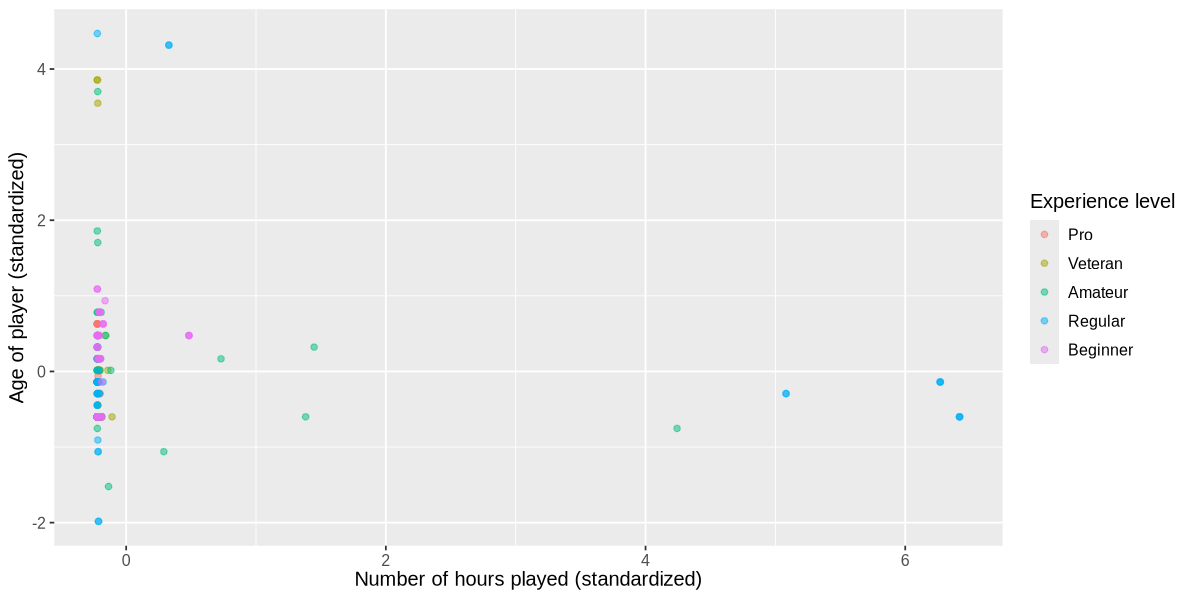

In [18]:
player_plot_data <- player_recipe |>
                        prep() |> # applies the preprocessing steps to the data
                        bake(new_data = NULL) # extract the transformed data frame

options(repr.plot.height = 5, repr.plot.width = 10)
player_plot <- player_plot_data |>
                 ggplot(aes(x = played_hours, y = Age, color = experience)) +
                 geom_point(alpha = 0.5) +
                 labs(x = "Number of hours played (standardized)",
                      y = "Age of player (standardized)",
                      color = "Experience level") +
                 theme(text = element_text(size = 12))
player_plot

After visualizing the data using a scatter plot, we observed no strong patterns distinguishing the classes. The points for different experience levels are highly mixed and overlapping across the feature space. 

This suggests that there may not be a strong relationship between these two predictors and response variable. We will note that as a result, the classifier may find it difficult to differentiate between the classes based on the 2 variables alone.

Although we didn't gain much insight from this plot, 


### Parameter value selection: choosing K

In order to choose our parameter K, k-fold cross validation will be performed using 5 folds. 

→ A | warning: ✖ No observations were detected in `truth` for level: Pro.
               ℹ Computation will proceed by ignoring those levels.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





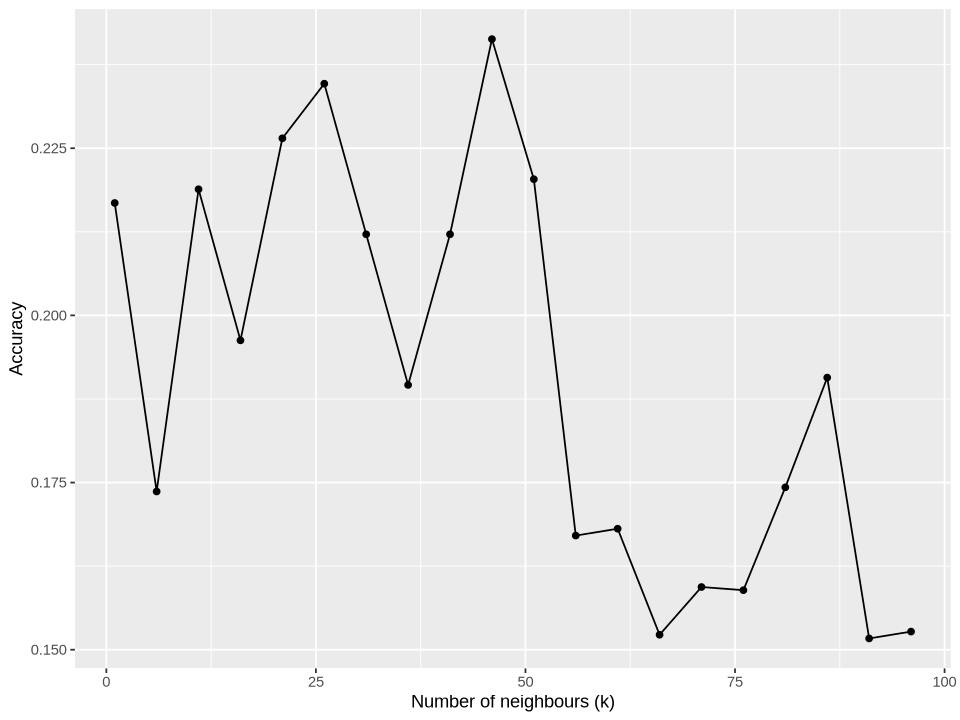

In [28]:
# setting a seed to make the results reproducible
set.seed(1234)

# create a model specification 
options(repr.plot.height = 6, repr.plot.width = 8)

knn_spec <- nearest_neighbor(weight_func = "rectangular", # to give each neighbour 1 vote
                             neighbors = tune()) |> # to select the optimal value of K
                set_engine("kknn") |> # to perform KNN classification
                set_mode("classification") # to specify that this is a classification problem

training_vfold <- vfold_cv(player_training, v = 5, # to perform a 5-fold cross validation
                           strata = experience) # to ensure that the training and validation subsets contain an equal proportion 

k_vals <- tibble(neighbors = seq(from = 1, to = 100, by = 5)) # to give a sequence of K values to try

knn_results <- workflow() |>
                add_recipe(player_recipe) |>
                add_model(knn_spec) |>
                tune_grid(resamples = training_vfold, grid = k_vals) # to fit the model for each K value

# evaluate the classifiers performance for each parameter value
accuracies <- knn_results |>
                collect_metrics() |>
                filter(.metric == "accuracy")

# plot accuracy vs. K to decide how many neighbours to choose
cross_val_plot <- accuracies |>
                    ggplot(aes(x = neighbors, y = mean)) +
                    geom_point() +
                    geom_line() +
                    labs(x = "Number of neighbours (k)", y = "Accuracy")
cross_val_plot

Since it is difficult to see what K value corresponds to the highest accuracy , 

In [29]:
best_k <- accuracies |>
        arrange(desc(mean)) |>
        head(1) |>
        pull(neighbors)
best_k

[1] 46

### Evaluating performance

In [31]:
# Create a new model, specifying that we want to use 66 nearest neighbours
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 46) |>
                set_engine("kknn") |>
                set_mode("classification")

knn_fit <- workflow() |>
            add_recipe(player_recipe) |>
            add_model(knn_spec) |>
            fit(data = player_training)

In [32]:
# evaluate the classifier using the testing set
player_predict <- knn_fit |>
                    predict(player_testing) |>
                    bind_cols(player_testing)

predict <- player_predict |>
  metrics(truth = experience, estimate = .pred_class) |>
  filter(.metric == "accuracy")
predict

.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,multiclass,0.2


# Discussion
- summarize what you found
- discuss whether this is what you expected to find?
- discuss what impact could such findings have?
- discuss what future questions could this lead to?